# Pseudolikelihood Maximisation (PLM)

In [1]:
from sympy import symbols, Sum, IndexedBase, log, cosh, diff, Piecewise, Ne, simplify
import sympy as sp

## 1. PLM for observed data

### 1.1 Equations

In [2]:
# Define the symbols for the dimensions and indices
n, d = symbols('n d', integer=True)
i, j, k = symbols('i j k', integer=True)

# Define the symbolic indexed bases for J, h, and X
J = IndexedBase('J', shape=(d, d))
h = IndexedBase('h', shape=(d,))
X = IndexedBase('X', shape=(n, d))

# Define S_ij excluding the k = j term
S_ij = Sum(Piecewise((J[j, k] * X[i, k], Ne(k, j))), (k, 1, d)) + h[j]

# Define the log-pseudolikelihood function LL
LL = Sum(X[i, j] * S_ij - log(2 * cosh(S_ij)), (i, 1, n), (j, 1, d))
LL

Sum(Piecewise(((h[j] + Sum(J[j, k]*X[i, k], (k, 1, d)))*X[i, j] - log(2*cosh(h[j] + Sum(J[j, k]*X[i, k], (k, 1, d)))), Ne(j, k))), (i, 1, n), (j, 1, d))

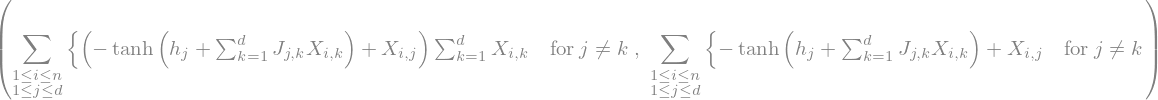

In [3]:
# Compute the symbolic gradients
grad_J_jk = diff(LL, J[j, k])
grad_h_j = diff(LL, h[j])

# Simplify the gradients
grad_J_jk_simplified = simplify(grad_J_jk)
grad_h_j_simplified = simplify(grad_h_j)

# Initialise pretty-printing
sp.init_printing(use_unicode=True)

# Display the expressions
grad_J_jk_simplified, grad_h_j_simplified

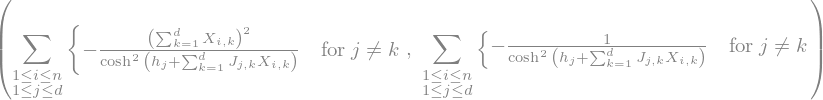

In [4]:
# Compute the symbolic second derivatives
hessian_J_jk = diff(grad_J_jk, J[j, k])
hessian_h_j = diff(grad_h_j, h[j])

# Simplify the second derivatives
hessian_J_jk_simplified = simplify(hessian_J_jk)
hessian_h_j_simplified = simplify(hessian_h_j)

# Display the expressions
hessian_J_jk_simplified, hessian_h_j_simplified

### 1.2. Implementation

In [5]:
import numpy as np
import pandas as pd
from Utility.decorators import timer

@timer
def log_pseudolikelihood_and_gradients_v1(J, h, X):
    """
    Initial code for calculating the log-pseudolikelihood and gradients closely follows my derived expression.
    """
    n, d = X.shape  # Number of samples and dimensions
    log_likelihood = 0
    grad_J = np.zeros_like(J)  # Initialise the gradient of J
    grad_h = np.zeros_like(h)  # Initialise the gradient of h

    for i in range(n):
        for j in range(d):
            # Compute S_ij
            S_ij = np.dot(J[j, :], X[i, :]) + h[j]
            
            # Update log-likelihood
            log_likelihood += S_ij * X[i, j] - np.log(2 * np.cosh(S_ij))
            
            # Update gradient of h
            grad_h[j] += -np.tanh(S_ij) + X[i, j]
            
            # Update gradient of J
            for k in range(d):
                if k != j:
                    grad_J[j, k] += (-np.tanh(S_ij) + X[i, j]) * X[i, k]
                    grad_J[k, j] = grad_J[j, k]  # Symmetric update

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h

@timer
def log_pseudolikelihood_and_gradients_v2(J, h, X):
    """
    Streamlined code for calculating the log-pseudolikelihood and gradients.
    """
    n, d = X.shape  # Number of samples and dimensions
    log_likelihood, grad_J, grad_h = 0, np.zeros_like(J), np.zeros_like(h)

    for i in range(n):
        for j in range(d):
            x_ij = X[i, j]
            S_ij = np.dot(J[j, :], X[i, :]) + h[j]
            log_likelihood += x_ij * S_ij - np.log(2 * np.cosh(S_ij))
            tanh_S_ij = np.tanh(S_ij)
            grad_h[j] += -tanh_S_ij + x_ij
            mask = np.ones(d, dtype=bool)
            mask[j] = False
            grad_J[j, mask] += (-tanh_S_ij + x_ij) * X[i, mask]
            grad_J[mask, j] = grad_J[j, mask]

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h

@timer
def log_pseudolikelihood_and_gradients_v3(J, h, X):
    """
    Vectorised code for super speedy performance.
    """
    d = X.shape[1]  # Number of dimensions
    grad_J, grad_h = np.zeros_like(J), np.zeros_like(h)

    # Vectorised version
    S_ij = X @ J + h  # Compute S_ij vectorised, broadcasting h
    log_likelihood = np.sum(X * S_ij) - np.sum(np.log(2 * np.cosh(S_ij)))

    tanh_S_ij = np.tanh(S_ij)
    grad_h = np.sum(X - tanh_S_ij, axis=0)

    # Compute the gradient for J, excluding the diagonal
    # Create a mask to zero out diagonal contributions in the grad_J calculation
    mask = np.ones_like(J) - np.eye(d)
    grad_J = ((X - tanh_S_ij).T @ X) * mask
    grad_J = (grad_J + grad_J.T)

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h

# Define test inputs
X = pd.read_csv('Results/data_matrix.csv').drop(columns=["Date"]).to_numpy()
n, d = X.shape

# Initialise J as a symmetric matrix with zeros on the diagonal
# Elements are drawn from a uniform distribution over [-1, 1]
J_upper = np.triu(np.random.uniform(-1, 1, size=(d, d)), 1)  # Upper triangular part with 1 offset to exclude diagonal
J = J_upper + J_upper.T  # Symmetric matrix with zeros on the diagonal

# Initialise h as a one-dimensional array (vector) of size d
# Elements are drawn from a uniform distribution over [-1, 1]
h = np.random.uniform(-1, 1, size=d)

def compare_pseudolikelihood_functions(J, h, X):
    # Function names in a dictionary for iteration
    functions = {
        'v1': log_pseudolikelihood_and_gradients_v1,
        'v2': log_pseudolikelihood_and_gradients_v2,
        'v3': log_pseudolikelihood_and_gradients_v3
    }

    # Run each function and store results
    results = {name: func(J, h, X) for name, func in functions.items()}

    # Print results for each function
    for name, result in results.items():
        print(f"\nFunction {name} Results:")
        print("-log_likelihood:", result[0])
        print("-grad_J:\n", result[1][:3, :3])  # Print a 3x3 submatrix
        print(f"-grad_h:{result[2][:3]}")  # Print first 3 elements

    # Define specific pairs to compare
    comparison_pairs = [('v1', 'v2'), ('v1', 'v3')]

    # Compare results between each specified pair of functions
    for name1, name2 in comparison_pairs:
        result1, result2 = results[name1], results[name2]
        ll_same = np.allclose(result1[0], result2[0])
        grad_J_same = np.allclose(result1[1], result2[1])
        grad_h_same = np.allclose(result1[2], result2[2])
        print(f"{name1} vs {name2}: "
              f"LL: {'Same' if ll_same else 'Different'}, "
              f"Grad_J: {'Same' if grad_J_same else 'Different'}, "
              f"Grad_h: {'Same' if grad_h_same else 'Different'}")

compare_pseudolikelihood_functions(J, h, X)


'log_pseudolikelihood_and_gradients_v1' execution time: 3.236128 seconds
'log_pseudolikelihood_and_gradients_v2' execution time: 1.007388 seconds
'log_pseudolikelihood_and_gradients_v3' execution time: 0.066629 seconds

Function v1 Results:
-log_likelihood: 302967.9665715675
-grad_J:
 [[   -0.         -2842.97603128 -4248.61656713]
 [-2842.97603128    -0.         -5699.24040876]
 [-4248.61656713 -5699.24040876    -0.        ]]
-grad_h:[  38.20344066 1493.31400289  200.51216449]

Function v2 Results:
-log_likelihood: 302967.9665715675
-grad_J:
 [[   -0.         -2842.97603128 -4248.61656713]
 [-2842.97603128    -0.         -5699.24040876]
 [-4248.61656713 -5699.24040876    -0.        ]]
-grad_h:[  38.20344066 1493.31400289  200.51216449]

Function v3 Results:
-log_likelihood: 302967.9665715696
-grad_J:
 [[   -0.         -2842.97603128 -4248.61656713]
 [-2842.97603128    -0.         -5699.24040876]
 [-4248.61656713 -5699.24040876    -0.        ]]
-grad_h:[  38.20344066 1493.31400289  200

### 1.3 Computing Hessian to check convexity

In [6]:
import numpy as np
import pandas as pd
from autograd import hessian
import autograd.numpy as anp

# Load data and initialise parameters
X = pd.read_csv('Results/data_matrix.csv').drop(columns=["Date"]).to_numpy()
n, d = X.shape
J_upper = np.triu(np.random.uniform(-1, 1, size=(d, d)), 1)
J = J_upper + J_upper.T
h = np.random.uniform(-1, 1, size=d)

# Flatten J and h
params = np.concatenate([J[np.triu_indices(d, 1)], h])

def reconstruct_J_and_h(flattened_array, d):
    J_upper_tri = flattened_array[:d * (d - 1) // 2]
    h = flattened_array[d * (d - 1) // 2:]

    # Construct the symmetric J matrix from the upper triangular part
    J = anp.zeros((d, d))
    rows = []
    start = 0
    for i in range(d):
        end = start + d - i - 1

        # Construct the upper part of the row
        upper_part = J_upper_tri[start:end]

        # Fill the rest with zeros (for the diagonal and the lower part)
        zeros = anp.zeros(i + 1)  # One extra zero for the diagonal

        # Combine to form the complete row
        row = anp.concatenate([zeros, upper_part])
        rows.append(row)

        start = end

    J = anp.array(rows)
    J += J.T  # Symmetrise the J matrix

    return J, h

# Define the log_pseudolikelihood function
def log_pseudolikelihood(params, X):
    J, h = reconstruct_J_and_h(params, X.shape[1])
    S_ij = X @ J + h
    return -(anp.sum(X * S_ij) - anp.sum(anp.log(2 * anp.cosh(S_ij))))

# Check reconstruction and convexity
J_reconstructed, h_reconstructed = reconstruct_J_and_h(params, d)
J_comparison = np.allclose(J, J_reconstructed)
h_comparison = np.allclose(h, h_reconstructed)
print(f"Are the reconstructed parameters the same as the originals? J: {J_comparison}, h: {h_comparison}")

# Compute the Hessian for J and h
H = hessian(log_pseudolikelihood)(params, X)

# Check if the Hessians are positive semi-definite and analyse eigenvalues
def check_convexity_and_eigenvalues(H):
    eigvals = np.linalg.eigvals(H)
    is_convex = np.all(eigvals >= 0)
    num_negative = np.sum(eigvals < 0)
    min_eigval = np.min(eigvals)
    return is_convex, num_negative, min_eigval

is_convex, num_negative, min_eigval = check_convexity_and_eigenvalues(H)

# Print results
print("Hessian - Convex:", is_convex, "Min Eigenvalue:", min_eigval, "Negative Eigenvalues:", num_negative)

Are the reconstructed parameters the same as the originals? J: True, h: True
Hessian - Convex: True Min Eigenvalue: 172.82102395577834 Negative Eigenvalues: 0


In [7]:
def sample_parameters(d, num_samples=100):
    for _ in range(num_samples):
        J_upper = np.triu(np.random.uniform(-1, 1, size=(d, d)), 1)
        h_sample = np.random.uniform(-1, 1, size=d)
        params_sample = np.concatenate([J_upper[np.triu_indices(d, 1)], h_sample])
        yield params_sample

num_samples = 100  # Adjust based on computational feasibility
for params_sample in sample_parameters(d, num_samples):
    H_sample = hessian(log_pseudolikelihood)(params_sample, X)
    is_convex, _, _ = check_convexity_and_eigenvalues(H_sample)
    if not is_convex:
        print("Found a point where the function is not convex")
        break
else:
    print("All sampled points indicate convexity")

All sampled points indicate convexity


### 1.4 Optimisation

subset_1: Currencies 1 to 7
subset_2: Currencies 8 to 14
subset_3: Currencies 15 to 20
subset_4: Currencies 21 to 26
Attempt 1 of optimisation
'_optimise_all_subsets' execution time: 0.803937 seconds
Optimisation successful.

Attempt 2 of optimisation
'_optimise_all_subsets' execution time: 0.573428 seconds
Optimisation successful.

Attempt 3 of optimisation
'_optimise_all_subsets' execution time: 0.512425 seconds
Optimisation successful.

Attempt 4 of optimisation
'_optimise_all_subsets' execution time: 0.460218 seconds
Optimisation successful.

Attempt 5 of optimisation
'_optimise_all_subsets' execution time: 0.798079 seconds
Optimisation successful.

Attempt 6 of optimisation
'_optimise_all_subsets' execution time: 0.432889 seconds
Optimisation successful.

Attempt 7 of optimisation
'_optimise_all_subsets' execution time: 0.482375 seconds
Optimisation successful.

Attempt 8 of optimisation
'_optimise_all_subsets' execution time: 1.018682 seconds
Optimisation successful.

Attempt 9 o

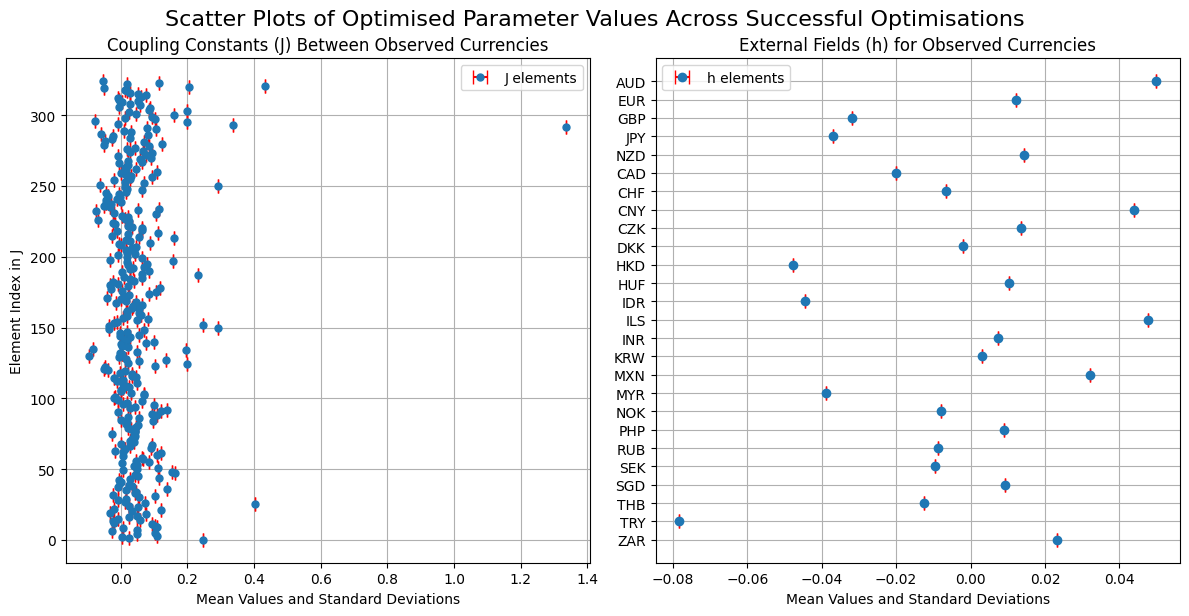

'train' execution time: 112.080406 seconds
The optimised J matrix has been saved to 'Results/J.csv'.
The optimised h vector has been saved to 'Results/h.csv'.
The standard deviation of J matrix has been saved to 'Results/J_std.csv'.
The standard deviation of h vector has been saved to 'Results/h_std.csv'.


In [8]:
from Utility.IsingOptimiser import IsingOptimiser
J_file_path='Results/J.csv'
h_file_path='Results/h.csv'
J_std_file_path='Results/J_std.csv'
h_std_file_path='Results/h_std.csv'

ising_optimiser = IsingOptimiser('Results/data_matrix.csv')
ising_optimiser.train()
ising_optimiser.save_results(J_file_path, h_file_path, J_std_file_path, h_std_file_path)

## 2. PLM including the hidden variable (Boltzmann Machine)

### 2.1 Equations

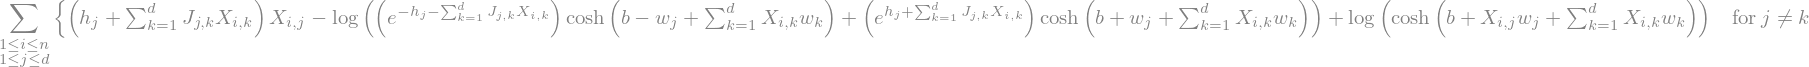

In [9]:
from sympy import symbols, Sum, IndexedBase, log, cosh, exp, diff, Piecewise, Ne, simplify

# Define the symbols for the dimensions and indices
n, d = symbols('n d', integer=True)
i, j, k = symbols('i j k', integer=True)
b = symbols('b', real=True)

# Define the symbolic indexed bases for J, h, w, and X
J = IndexedBase('J', shape=(d, d))
h = IndexedBase('h', shape=(d,))
w = IndexedBase('w', shape=(d,))
X = IndexedBase('X', shape=(n, d))

# Define S_ij and S_ik excluding the k = j term
S_ij = Sum(Piecewise((J[j, k] * X[i, k], Ne(k, j))), (k, 1, d)) + h[j]
S_ik = Sum(Piecewise((w[k] * X[i, k], Ne(k, j))), (k, 1, d)) + b

# Define the log-pseudolikelihood function LL
LL = Sum(X[i, j] * S_ij + log(cosh(w[j] * X[i, j] + S_ik)) - log(
    exp(S_ij) * cosh(w[j] + S_ik) + exp(-S_ij) * cosh(-w[j] + S_ik)), (i, 1, n), (j, 1, d))
LL

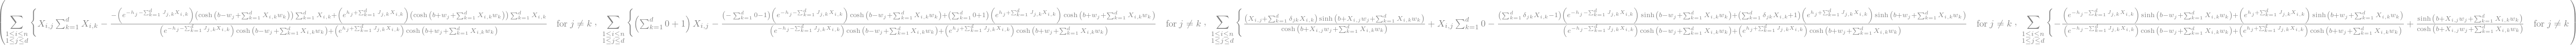

In [10]:
# Compute the symbolic gradients
grad_J_jk = diff(LL, J[j, k])
grad_h_j = diff(LL, h[j])
grad_w_j = diff(LL, w[j])
grad_b = diff(LL, b)

# Display the expressions
grad_J_jk, grad_h_j, grad_w_j, grad_b

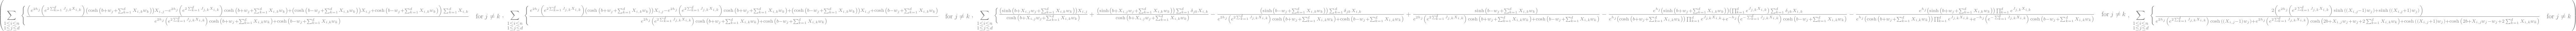

In [11]:
# Simplify the gradients (which only made things more complicated)
grad_J_jk_simplified = simplify(grad_J_jk)
grad_h_j_simplified = simplify(grad_h_j)
grad_w_j_simplified = simplify(grad_w_j)
grad_b_simplified = simplify(grad_b)

# Display the expressions
grad_J_jk_simplified, grad_h_j_simplified, grad_w_j_simplified, grad_b_simplified

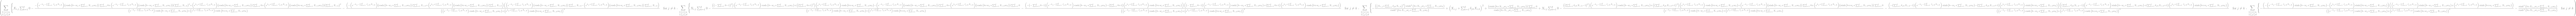

In [12]:
# Compute the symbolic second derivatives
hessian_J_jk = diff(grad_J_jk, J[j, k])
hessian_h_j = diff(grad_h_j, h[j])
hessian_w_j = diff(grad_w_j, w[j])
hessian_b = diff(grad_b, b)

# Display the expressions
hessian_J_jk, hessian_h_j, hessian_w_j, hessian_b

### 2.2 Implementation

In [13]:
import numpy as np
import pandas as pd
from Utility.decorators import timer

@timer
def log_pseudolikelihood_v1(J, h, w, b, X):
    n, d = X.shape  # Number of samples and dimensions

    # Initialise the log pseudolikelihood (LL) and the gradients of J, h, w and b
    log_likelihood = 0
    grad_J, grad_h, grad_w, grad_b = np.zeros_like(J), np.zeros_like(h), np.zeros_like(w), 0

    for i in range(n):
        for j in range(d):
            x_ij = X[i, j]

            # Compute S_ij without the contribution from the j-th term
            S_ij = np.dot(J[j, :], X[i, :]) + h[j]
            
            # Compute S_ik without the contribution from the j-th term
            S_ik = np.dot(w, X[i, :]) + b - w[j] * x_ij

            # components used in the LL and gradients
            exp_pos_Sij = np.exp(S_ij)
            exp_neg_Sij = np.exp(-S_ij)
            cosh_pos = np.cosh(S_ik + w[j])
            cosh_neg = np.cosh(S_ik - w[j])
            sinh_pos = np.sinh(S_ik + w[j])
            sinh_neg = np.sinh(S_ik - w[j])
            denominator = exp_pos_Sij * cosh_pos + exp_neg_Sij * cosh_neg

            # Update the new LL expression
            log_likelihood += (
                x_ij * S_ij +
                np.log(np.cosh(w[j] * x_ij + S_ik)) -
                np.log(denominator)
            )

            # grad_h update
            numerator_h = -exp_neg_Sij * cosh_neg + exp_pos_Sij * cosh_pos
            grad_h[j] += x_ij - (numerator_h / denominator)

            # grad_w update
            numerator_w = -exp_neg_Sij * sinh_neg + exp_pos_Sij * sinh_pos
            grad_w[j] += x_ij * np.tanh(S_ik + w[j] * x_ij) - (numerator_w / denominator)

            # grad_b update
            numerator_b = exp_neg_Sij * sinh_neg + exp_pos_Sij * sinh_pos
            grad_b += np.tanh(S_ik + w[j] * x_ij) - (numerator_b / denominator)

            # grad_J update
            numerator_J = -exp_neg_Sij * cosh_neg + exp_pos_Sij * cosh_pos
            for k in range(d):
                if k != j:
                    grad_J[j, k] += (x_ij - (numerator_J / denominator)) * X[i, k]
                    grad_J[k, j] = grad_J[j, k]  # Symmetric update

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h, -grad_w, -grad_b

@timer
def log_pseudolikelihood_v2(J, h, w, b, X):
    n, d = X.shape  # Number of samples and dimensions
    log_likelihood = 0
    grad_J, grad_h, grad_w, grad_b = np.zeros_like(J), np.zeros_like(h), np.zeros_like(w), 0

    for i in range(n):
        full_S_ik = np.dot(w, X[i, :]) + b
        for j in range(d):
            x_ij = X[i, j]
            S_ij = np.dot(J[j, :], X[i, :]) + h[j]
            S_ik = np.dot(w, X[i, :]) - w[j] * x_ij + b

            exp_pos_Sij = np.exp(S_ij)
            exp_neg_Sij = np.exp(-S_ij)
            cosh_pos = np.cosh(S_ik + w[j])
            cosh_neg = np.cosh(S_ik - w[j])
            sinh_pos = np.sinh(S_ik + w[j])
            sinh_neg = np.sinh(S_ik - w[j])
            denominator = exp_pos_Sij * cosh_pos + exp_neg_Sij * cosh_neg

            # LL update
            log_likelihood += (
                x_ij * S_ij +
                np.log(np.cosh(full_S_ik)) -
                np.log(denominator)
            )

            # grad_h update
            numerator_h = -exp_neg_Sij * cosh_neg + exp_pos_Sij * cosh_pos
            grad_h[j] += x_ij - (numerator_h / denominator)

            # grad_w update
            numerator_w = -exp_neg_Sij * sinh_neg + exp_pos_Sij * sinh_pos
            grad_w[j] += x_ij * np.tanh(full_S_ik) - (numerator_w / denominator)

            # grad_b update
            numerator_b = exp_neg_Sij * sinh_neg + exp_pos_Sij * sinh_pos
            grad_b += np.tanh(full_S_ik) - (numerator_b / denominator)

            # grad_J update
            mask = np.ones(d, dtype=bool)
            mask[j] = False
            numerator_J = -exp_neg_Sij * cosh_neg + exp_pos_Sij * cosh_pos
            grad_J[j, mask] += (x_ij - (numerator_J / denominator)) * X[i, mask]
            grad_J[mask, j] = grad_J[j, mask]  # Symmetric update

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h, -grad_w, -grad_b

@timer
def log_pseudolikelihood_v3(J, h, w, b, X):
    d = X.shape[1]  # Number of dimensions

    S_ij = X @ J + h  # Broadcasting h
    full_S_ik = X @ w + b  # for all samples
    S_ik = X @ w.reshape(-1, 1) + b - X * w  # Broadcasting w

    # Calculate the components used in the log likelihood and gradients
    exp_pos_Sij = np.exp(S_ij)
    exp_neg_Sij = 1 / exp_pos_Sij
    cosh_pos = np.cosh(S_ik + w)
    cosh_neg = np.cosh(S_ik - w)
    sinh_pos = np.sinh(S_ik + w)
    sinh_neg = np.sinh(S_ik - w)
    denominator = exp_pos_Sij * cosh_pos + exp_neg_Sij * cosh_neg

    x_times_Sij = X * S_ij  # Sum over dimensions for each sample
    log_numerator = np.log(np.cosh(full_S_ik.reshape(-1, 1)))  # Reshape to 2D
    log_denominator = np.log(denominator)  # Sum over dimensions for each sample

    # Combine the terms and sum over all samples to get the scalar log-likelihood
    log_likelihood = np.sum(x_times_Sij + log_numerator - log_denominator)

    # Gradients for h, w, and b
    numerator_h = -exp_neg_Sij * cosh_neg + exp_pos_Sij * cosh_pos
    grad_h = np.sum(X - numerator_h / denominator, axis=0)

    numerator_w = -exp_neg_Sij * sinh_neg + exp_pos_Sij * sinh_pos
    grad_w = np.sum(X.T * np.tanh(full_S_ik.T) - (numerator_w / denominator).T, axis=1)

    numerator_b = exp_neg_Sij * sinh_neg + exp_pos_Sij * sinh_pos
    grad_b = np.sum(np.tanh(full_S_ik.reshape(-1, 1)) - (numerator_b / denominator))

    # Gradient for J, excluding the diagonal
    mask = np.ones_like(J) - np.eye(d)
    numerator_J = -exp_neg_Sij * cosh_neg + exp_pos_Sij * cosh_pos
    grad_J = ((X - numerator_J / denominator).T @ X) * mask
    grad_J = grad_J + grad_J.T  # Symmetrise

    # Return the negative likelihood and gradients for minimisation
    return -log_likelihood, -grad_J, -grad_h, -grad_w, -grad_b

# Read data
X = pd.read_csv('Results/data_matrix.csv').drop(columns=["Date"]).to_numpy()
J = pd.read_csv("Results/J.csv").values
h = pd.read_csv("Results/h.csv", header=None)[1].values
n, d = X.shape

# Initialise w and b
w = np.random.uniform(-1, 1, size=d)
b = np.random.uniform(-1, 1)

# Function to compare pseudolikelihood functions
def compare_pseudolikelihood_functions(J, h, w, b, X):
    functions = {
        'v1': log_pseudolikelihood_v1,
        'v2': log_pseudolikelihood_v2,
        'v3': log_pseudolikelihood_v3
    }

    results = {name: func(J, h, w, b, X) for name, func in functions.items()}

    for name, result in results.items():
        print(f"\nFunction {name} Results:")
        print("-log_likelihood:", result[0])
        print("-grad_J:\n", result[1][:3, :3])
        print(f"-grad_h:{result[2][:3]}")
        print(f"-grad_w:{result[3][:3]}")
        print(f"-grad_b:{result[4]}")

    comparison_pairs = [('v1', 'v2'), ('v1', 'v3')]

    # Compare results between each specified pair of functions
    for name1, name2 in comparison_pairs:
        result1, result2 = results[name1], results[name2]
        ll_same = np.allclose(result1[0], result2[0])
        grad_J_same = np.allclose(result1[1], result2[1])
        grad_h_same = np.allclose(result1[2], result2[2])
        grad_w_same = np.allclose(result1[3], result2[3])
        grad_b_same = np.allclose(result1[4], result2[4])
        print(f"{name1} vs {name2}: "
              f"LL: {'Same' if ll_same else 'Different'}, "
              f"Grad_J: {'Same' if grad_J_same else 'Different'}, "
              f"Grad_h: {'Same' if grad_h_same else 'Different'}, "
              f"Grad_w: {'Same' if grad_w_same else 'Different'}, "
              f"Grad_b: {'Same' if grad_b_same else 'Different'}")

compare_pseudolikelihood_functions(J, h, w, b, X)


'log_pseudolikelihood_v1' execution time: 2.556283 seconds
'log_pseudolikelihood_v2' execution time: 1.708036 seconds
'log_pseudolikelihood_v3' execution time: 0.038784 seconds

Function v1 Results:
-log_likelihood: 72317.58685811807
-grad_J:
 [[ -0.          84.65115101 306.53691578]
 [ 84.65115101  -0.         -11.88898307]
 [306.53691578 -11.88898307  -0.        ]]
-grad_h:[ 48.13445665  42.52569119 193.67275252]
-grad_w:[ 346.03741159  233.13112245 1104.80463811]
-grad_b:-44.31262033229124

Function v2 Results:
-log_likelihood: 72317.58685811807
-grad_J:
 [[ -0.          84.65115101 306.53691578]
 [ 84.65115101  -0.         -11.88898307]
 [306.53691578 -11.88898307  -0.        ]]
-grad_h:[ 48.13445665  42.52569119 193.67275252]
-grad_w:[ 346.03741159  233.13112245 1104.80463811]
-grad_b:-44.31262033229114

Function v3 Results:
-log_likelihood: 72317.58685811782
-grad_J:
 [[ -0.          84.65115101 306.53691578]
 [ 84.65115101  -0.         -11.88898307]
 [306.53691578 -11.88898307 

### 2.3 Computing Hessian to check convexity

In [17]:
import numpy as np
import pandas as pd
from autograd import hessian
import autograd.numpy as anp

# Load data and initialise parameters
X = pd.read_csv('Results/data_matrix.csv').drop(columns=["Date"]).to_numpy()
J = pd.read_csv("Results/J.csv").values
h = pd.read_csv("Results/h.csv", header=None)[1].values
n, d = X.shape
w = np.random.uniform(-1, 1, size=d)
b = np.random.uniform(-1, 1)

# Concatenate parameters
params = np.concatenate([J[np.triu_indices(d, 1)], h, w, np.array([b])])

def reconstruct_parameters(flattened_array, d):
    num_J_elements = d * (d - 1) // 2
    J_upper_tri = flattened_array[:num_J_elements]
    h = flattened_array[num_J_elements:num_J_elements + d]
    w = flattened_array[num_J_elements + d:-1]
    b = flattened_array[-1]  # Last element is scalar b

    # Construct the symmetric J matrix from the upper triangular part
    J = anp.zeros((d, d))
    rows = []
    start = 0
    for i in range(d):
        end = start + d - i - 1

        # Construct the upper part of the row
        upper_part = J_upper_tri[start:end]

        # Fill the rest with zeros (for the diagonal and the lower part)
        zeros = anp.zeros(i + 1)  # One extra zero for the diagonal

        # Combine to form the complete row
        row = anp.concatenate([zeros, upper_part])
        rows.append(row)

        start = end

    J = anp.array(rows)
    J += J.T  # Symmetrise the J matrix

    return J, h, w, b

# Define the log_pseudolikelihood function
def log_pseudolikelihood(params, X):
    J, h, w, b = reconstruct_parameters(params, X.shape[1])
    S_ij = X @ J + h  # Broadcasting h
    full_S_ik = X @ w + b  # for all samples
    S_ik = X @ w.reshape(-1, 1) + b - X * w  # Broadcasting w

    # Calculate the components used in the log likelihood
    exp_pos_Sij = anp.exp(S_ij)
    exp_neg_Sij = 1 / exp_pos_Sij
    cosh_pos = anp.cosh(S_ik + w)
    cosh_neg = anp.cosh(S_ik - w)
    denominator = exp_pos_Sij * cosh_pos + exp_neg_Sij * cosh_neg

    x_times_Sij = X * S_ij  # Sum over dimensions for each sample
    log_numerator = anp.log(anp.cosh(full_S_ik.reshape(-1, 1)))  # Reshape to 2D
    log_denominator = anp.log(denominator)  # Sum over dimensions for each sample
    return -anp.sum(x_times_Sij + log_numerator - log_denominator)

# Check reconstruction and convexity
J_reconstructed, h_reconstructed, w_reconstructed, b_reconstructed = reconstruct_parameters(params, d)
J_comparison = np.allclose(J, J_reconstructed)
h_comparison = np.allclose(h, h_reconstructed)
w_comparison = np.allclose(w, w_reconstructed)
b_comparison = np.allclose(b, b_reconstructed)
print(f"Are the reconstructed parameters the same as the originals? J: {J_comparison}, h: {h_comparison}, w: {w_comparison}, b: {b_comparison}")

# Check if the Hessians are positive semi-definite and analyse eigenvalues
def check_convexity_and_eigenvalues(H):
    eigvals = np.linalg.eigvals(H)
    is_convex = np.all(eigvals >= 0)
    num_negative = np.sum(eigvals < 0)
    min_eigval = np.min(eigvals)
    return is_convex, num_negative, min_eigval

H = hessian(log_pseudolikelihood)(params, X)
is_convex, num_negative, min_eigval = check_convexity_and_eigenvalues(H)

# Print results
print("Hessian - Convex:", is_convex, "Min Eigenvalue:", min_eigval, "Negative Eigenvalues:", num_negative)

Are the reconstructed parameters the same as the originals? J: True, h: True, w: True, b: True
Hessian - Convex: False Min Eigenvalue: -5031.536276794759 Negative Eigenvalues: 23


In [18]:
def sample_parameters(d, num_samples=100):
    for _ in range(num_samples):
        w_sample = np.random.uniform(-1, 1, size=d)
        b_sample = np.random.uniform(-1, 1)
        params_sample = np.concatenate([J[np.triu_indices(d, 1)], h, w_sample, np.array([b_sample])])
        yield params_sample

num_samples = 10  # Adjust based on computational feasibility
for params_sample in sample_parameters(d, num_samples):
    H_sample = hessian(log_pseudolikelihood)(params_sample, X)
    is_convex, _, _ = check_convexity_and_eigenvalues(H_sample)
    if not is_convex:
        print("Found a point where the function is not convex")
        break
else:
    print("All sampled points indicate convexity")

Found a point where the function is not convex


In [20]:
sub_H1 = H[:351, :351]
sub_H2 = H[:377, :377]
sub_H3 = H
check_convexity_and_eigenvalues(sub_H1), check_convexity_and_eigenvalues(sub_H2), check_convexity_and_eigenvalues(sub_H3)

((True, 0, 554.5401096561684),
 (False, 22, -5006.543894577296),
 (False, 23, -5031.536276794759))

In [21]:
sub_eigvals1 = np.linalg.eigvals(sub_H1)
sub_eigvals2 = np.linalg.eigvals(sub_H2)
sub_eigvals3 = np.linalg.eigvals(sub_H3)
sub_eigvals1[sub_eigvals1 < 0], sub_eigvals2[sub_eigvals2 < 0], sub_eigvals3[sub_eigvals3 < 0]

(array([], dtype=float64),
 array([-5006.54389458, -1910.23609442, -1473.56603474, -1358.04212814,
        -1227.87967815, -1122.23880693, -1004.163926  ,  -949.30508916,
         -902.0917996 ,  -834.59566938,  -757.64260947,  -632.90519167,
         -547.38877963,  -452.43182527,  -420.40567545,  -360.57999947,
         -291.21275542,  -261.00639361,  -127.6859169 ,  -105.40447506,
          -96.38605042,   -27.39594483]),
 array([-5031.53627679, -1983.50933548, -1482.79292026, -1429.83065479,
        -1228.8567296 , -1122.32679094, -1050.85746234,  -996.50561837,
         -910.34125243,  -835.73337958,  -781.10194851,  -743.90090966,
         -626.99306234,  -534.52388351,  -437.93071571,  -352.13046508,
         -403.40808465,  -290.85275283,  -258.51839646,  -127.16647062,
         -105.34191626,   -95.00697604,   -15.771835  ]))

### 2.4 Optimisation

Attempt 1 of optimisation
'_optimise_model' execution time: 5.413986 seconds
Optimisation successful.

Attempt 2 of optimisation
'_optimise_model' execution time: 4.340966 seconds
Optimisation successful.

Attempt 3 of optimisation
'_optimise_model' execution time: 12.009863 seconds
Optimisation successful.

Attempt 4 of optimisation
'_optimise_model' execution time: 5.366211 seconds
Optimisation successful.

Attempt 5 of optimisation
'_optimise_model' execution time: 2.415717 seconds
Optimisation successful.

Attempt 6 of optimisation
'_optimise_model' execution time: 2.341888 seconds
Optimisation successful.

Attempt 7 of optimisation
'_optimise_model' execution time: 6.223600 seconds
Optimisation successful.

Attempt 8 of optimisation
'_optimise_model' execution time: 4.534318 seconds
Optimisation successful.

Attempt 9 of optimisation
'_optimise_model' execution time: 8.236338 seconds
Optimisation successful.

Attempt 10 of optimisation
'_optimise_model' execution time: 10.525818 s

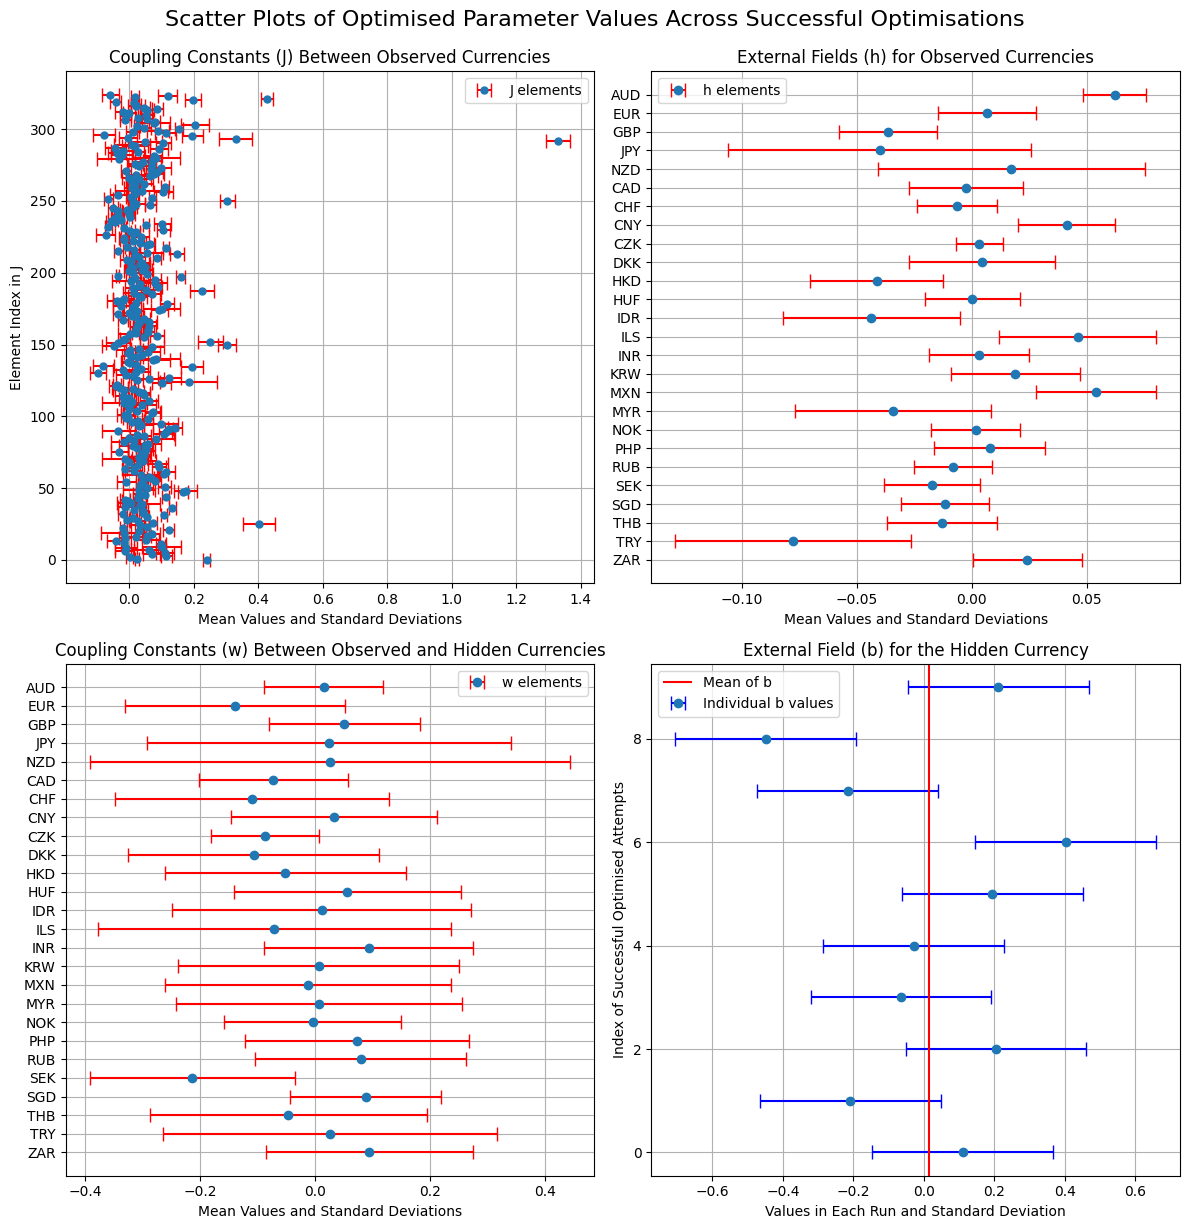

In [22]:
import pandas as pd
from Utility.BoltzmannMachine import BoltzmannMachine

data_matrix_df = pd.read_csv("Results/data_matrix.csv")
J_df = pd.read_csv("Results/J.csv")
h_df = pd.read_csv("Results/h.csv", header=None)

bm = BoltzmannMachine(data_matrix_df, J_df, h_df)
bm.train(max_attempts=100)

In [ ]:
bm.save_results('Results/J_opt.csv', 'Results/h.opt_csv',
                'Results/J_opt_extended.csv', 'Results/h_opt_extended.csv', 'Results/data_matrix_extended.csv')

### Using options
- After 100 successful optimisations with 103 attempts and 1 runtime warning
- 'train' execution time: 785.188534 seconds
- options = {'maxiter': 100000, 'ftol': 1e-12, 'gtol': 1e-9}

<img src="Images/options_init.png"/>

### Using weight initialisation in the training of neural networks
- After 100 successful optimisations with 101 attempts and 1 runtime warning
- 'train' execution time: 590.180103 seconds
- w = np.random.normal(0, np.sqrt(2 / d), size=(d,))  # Xavier initialisation
- b = np.random.normal(0, np.sqrt(2 / d))  # He initialisation

<img src="Images/weight_init.png"/>

### Using uniform initialisations
- After 100 successful optimisations with 102 attempts and 2 runtime warnings
- 'train' execution time: 555.127309 seconds
- w = np.random.uniform(-1, 1, size=d)
- b = np.random.uniform(-1, 1)

<img src="Images/uniform_init.png"/>

### 2.5 Trend analysis including the hidden variable

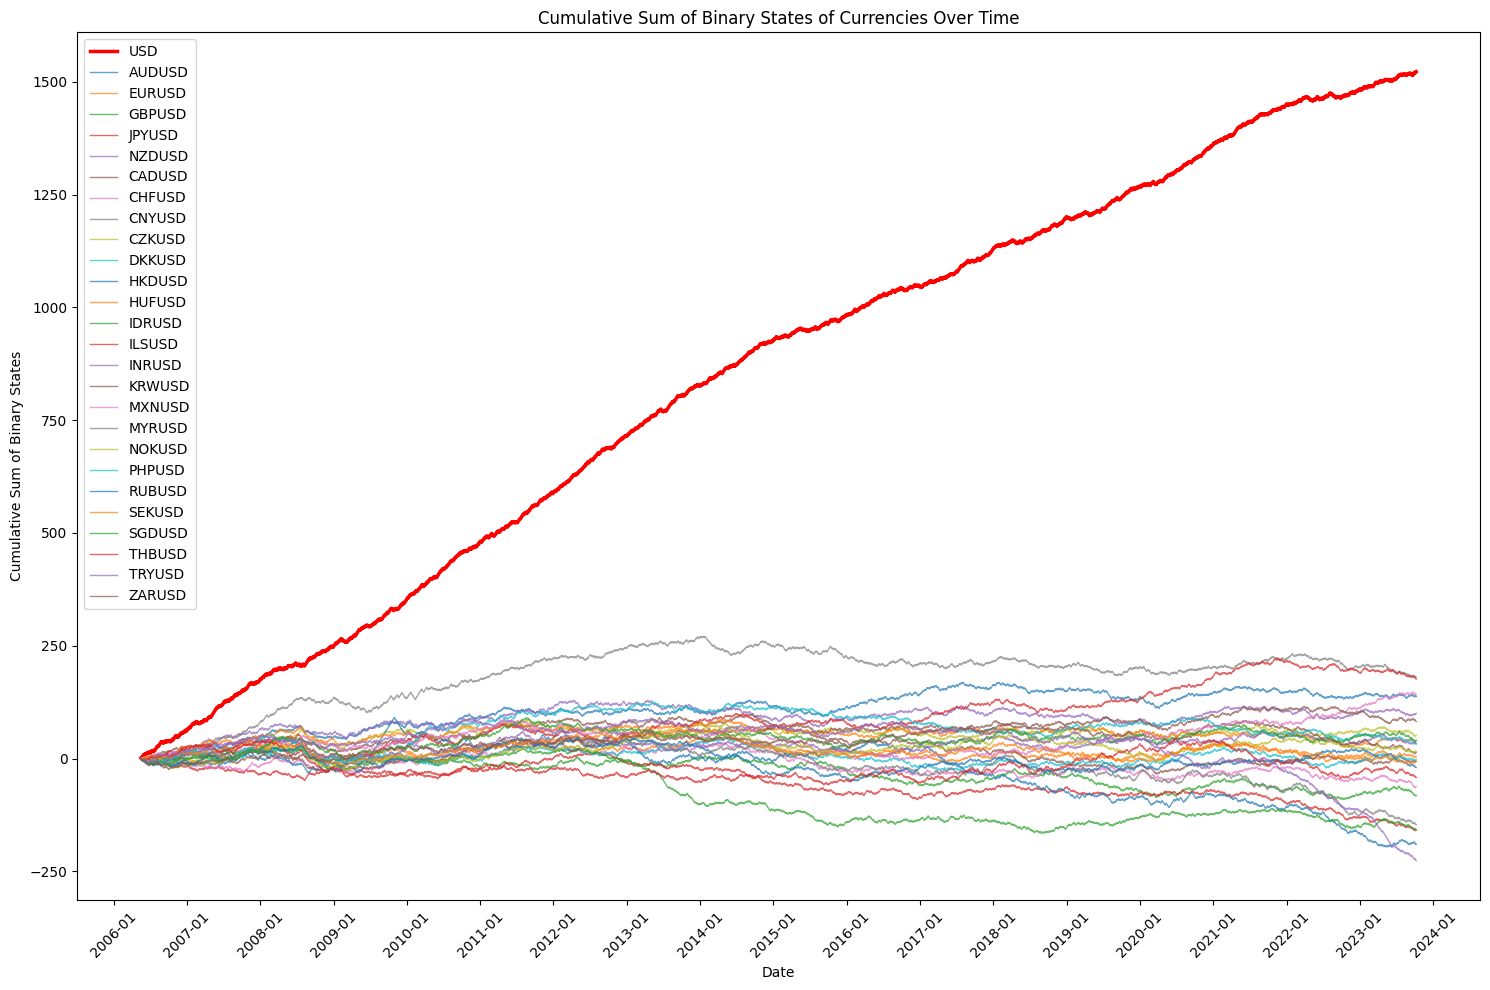

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def format_date_axis():
    """Formats the date axis with year and month."""
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.xticks(rotation=45)

def plot_cumulative_binary_states(data, cumsum_data, title, highlight_currency=None):
    """Plots the cumulative sum of binary states for given currencies."""
    plt.figure(figsize=(15, 10))
    for column in cumsum_data.columns:
        if column == highlight_currency:
            # Highlight the specified currency with a different style
            plt.plot(data['Date'], cumsum_data[column], label=column, linewidth=2.5, color='red')
        else:
            plt.plot(data['Date'], cumsum_data[column], label=column, linewidth=1, alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Sum of Binary States')
    plt.title(title)
    format_date_axis()
    plt.legend()
    plt.tight_layout()
    plt.show()

# Read and process data
data_matrix_extended = pd.read_csv("Results/data_matrix_extended.csv")

# Convert the 'Date' column to datetime and sort the data
data_matrix_extended['Date'] = pd.to_datetime(data_matrix_extended['Date'])

# Cumulative sum of binary states
data_matrix_cumsum = data_matrix_extended.drop(columns=['Date']).cumsum()

# Plot with USD highlighted
plot_cumulative_binary_states(data_matrix_extended, data_matrix_cumsum, 
                            'Cumulative Sum of Binary States of Currencies Over Time', 
                            highlight_currency='USD')

## 3. Power Law Fit

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

def extract_J(file):
    J = pd.read_csv(file).values
    d = J.shape[0]
    upper_triangle = J[np.triu_indices(d, k=1)]
    positive_values = upper_triangle[upper_triangle > 0]
    negative_values = upper_triangle[upper_triangle < 0]
    return positive_values, abs(negative_values)

# MLE estimation function to fit power law
def estimate_power_law_params(J):
    def log_likelihood(J, a, k):
        n = len(J)
        log_likelihood = np.sum(np.log(a) - k * np.log(J))
        grad_a = n / a
        grad_k = -np.sum(np.log(J))
        return -log_likelihood, -grad_a, -grad_k

    def objective_function(x):
        a, k = x
        LL, grad_a, grad_k = log_likelihood(J, a, k)
        return LL, np.array([grad_a, grad_k])

    while True:
        a = np.random.uniform(0, 1)
        k = np.random.uniform(0, 1)
        x0 = np.array([a, k])

        res = minimize(objective_function, x0, method='L-BFGS-B', jac=True)

        a_estimate, k_estimate = res.x
        if 0 < a_estimate < 1 and 0 < k_estimate < 1:
            break

    return a_estimate, k_estimate

# Estimate parameters for positive and absolute negative values
positive_values, negative_values = extract_J('Results/J.csv')
a_positive, k_positive = estimate_power_law_params(positive_values)
a_negative, k_negative = estimate_power_law_params(negative_values)

a_positive, k_positive, a_negative, k_negative

(0.94072859489118,
 0.034087603275569034,
 0.8978219317951357,
 0.5537687515325947)

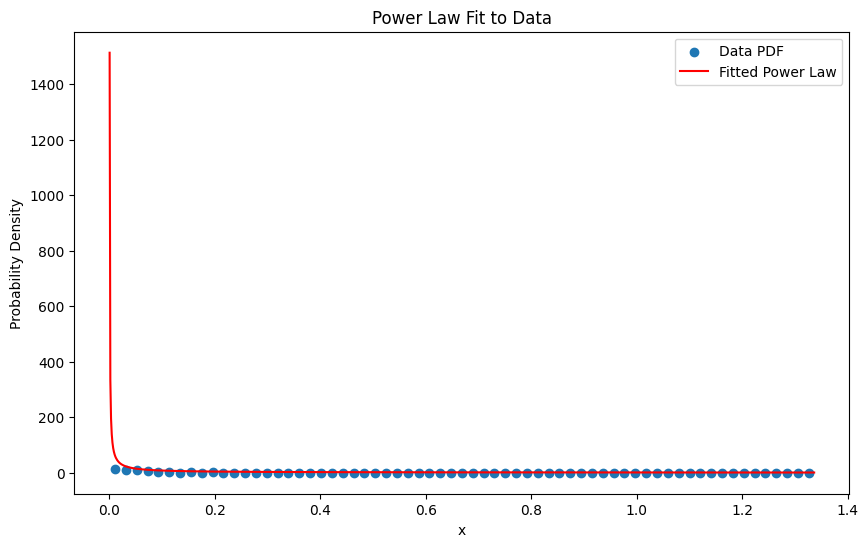

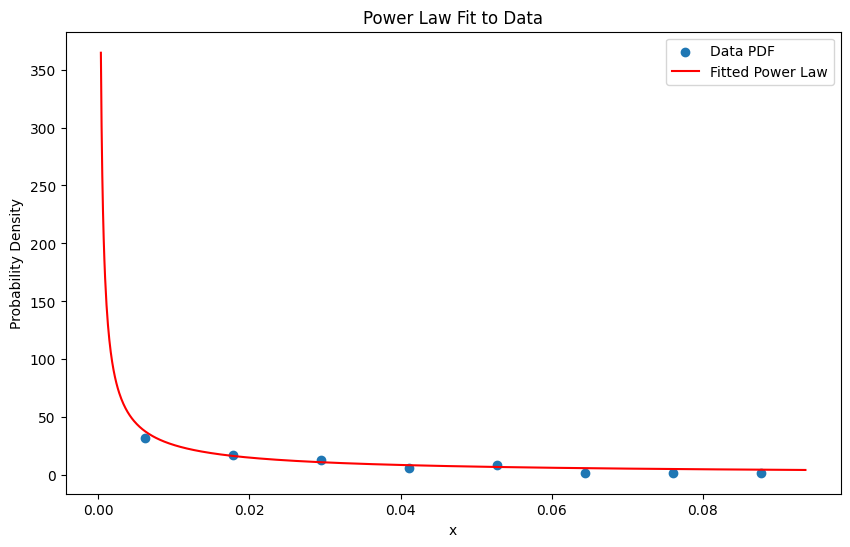

((0.9447102768360507, 0.9170379951646705),
 (0.7312838955272182, 0.7766358717760842))

In [ ]:
import matplotlib.pyplot as plt

def plot_power_law_pdf(data):
    # Prepare the data for PDF
    data_hist, bin_edges = np.histogram(data, bins='auto', density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Estimate parameters using MLE
    a, k = estimate_power_law_params(data)

    # Generating values for the fitted line
    x = np.linspace(min(data), max(data), 1000)
    y_fit = a * x**-k

    plt.figure(figsize=(10, 6))
    plt.scatter(bin_centers, data_hist, label='Data PDF')
    plt.plot(x, y_fit, color='red', label='Fitted Power Law')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.title('Power Law Fit to Data')
    plt.legend()
    plt.show()

    return x, y_fit, (a, k)

_, _, params_pos = plot_power_law_pdf(positive_values)
_, _, params_neg = plot_power_law_pdf(negative_values)
params_pos, params_neg

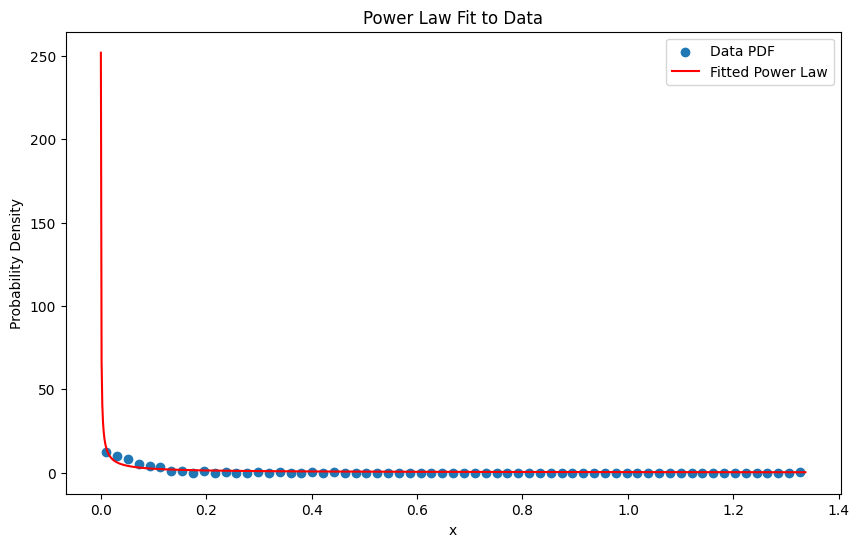

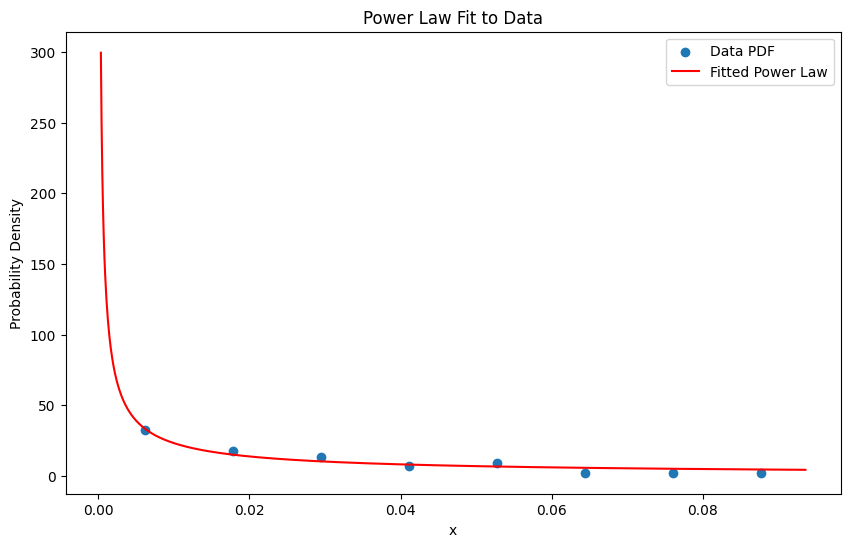

(array([0.36783275, 0.81138732]), array([0.7185601, 0.7542765]))

In [ ]:
from scipy.optimize import curve_fit

def plot_power_law_pdf_2(data):
    # Prepare the data for PDF
    data_hist, bin_edges = np.histogram(data, bins='auto', density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Fitting the power law using curve_fit
    power_law_func = lambda x, a, b: a * x**-b
    params, _ = curve_fit(power_law_func, bin_centers, data_hist, maxfev=5000)

    # Generating values for the fitted line
    x = np.linspace(min(data), max(data), 1000)
    y_fit = power_law_func(x, *params)

    plt.figure(figsize=(10, 6))
    plt.scatter(bin_centers, data_hist, label='Data PDF')
    plt.plot(x, y_fit, color='red', label='Fitted Power Law')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.title('Power Law Fit to Data')
    plt.legend()
    plt.show()

    return x, y_fit, params

_, _, params_pos = plot_power_law_pdf_2(positive_values)
_, _, params_neg = plot_power_law_pdf_2(negative_values)
params_pos, params_neg

Powerlaw: a Python package for analysis of heavy-tailed distributions
https://arxiv.org/abs/1305.0215

- R (Loglikelihood Ratio): This value compares how well two distributions (e.g., power law vs. exponential) fit the data. A positive R value indicates that the first distribution (power law in this case) is a better fit. A negative value suggests the second distribution (e.g., exponential) fits better.
- p-value: This is a measure of the statistical significance of the R value. A low p-value (commonly < 0.05) suggests that the observed difference in fit between the two distributions is statistically significant. A high p-value indicates that the difference might be due to random chance, and there is no strong preference for one model over the other.

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


/Users/mizz/Library/Python/3.9/lib/python/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


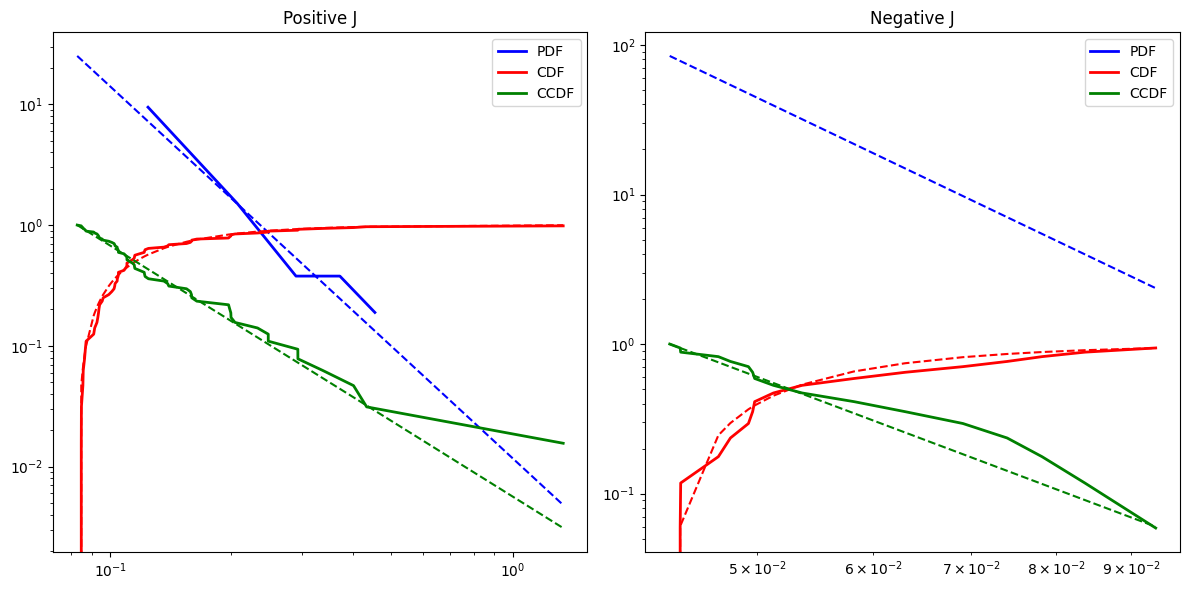

Comparative Statistical Analysis for Positive J:
          Power Law  exponential  lognormal  stretched_exponential
alpha      3.075122          NaN        NaN                    NaN
sigma      0.259390          NaN        NaN                    NaN
xmin       0.082670          NaN        NaN                    NaN
J min      0.000320          NaN        NaN                    NaN
J max      1.336622          NaN        NaN                    NaN
LL Ratio        NaN     1.449526  -1.016846               0.568817
p-value         NaN     0.147191   0.309227               0.569480

Comparative Statistical Analysis for Negative J:
          Power Law  exponential  lognormal  stretched_exponential
alpha      4.681504          NaN        NaN                    NaN
sigma      0.892896          NaN        NaN                    NaN
xmin       0.043579          NaN        NaN                    NaN
J min      0.000336          NaN        NaN                    NaN
J max      0.093555          N

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import powerlaw

def plot_powerlaw_fit(ax, data, title):
    # Fit the data
    fit = powerlaw.Fit(data)
    
    # Initialise results dictionary
    results = {
        'Power Law': {'alpha': fit.power_law.alpha, 'sigma': fit.power_law.sigma, 
                      'xmin': fit.xmin, 'J min': min(data), 'J max': max(data)},
    }

    # Plot PDF, CDF, CCDF
    fit.plot_pdf(color='b', linewidth=2, ax=ax, label='PDF')
    fit.power_law.plot_pdf(data, color='b', linestyle='--', ax=ax)
    fit.plot_cdf(color='r', linewidth=2, ax=ax, label='CDF')
    fit.power_law.plot_cdf(data, color='r', linestyle='--', ax=ax)
    fit.plot_ccdf(color='g', linewidth=2, ax=ax, label='CCDF')
    fit.power_law.plot_ccdf(data, color='g', linestyle='--', ax=ax)

    # Add legend
    ax.legend()

    # Compare with other distributions
    for distribution in ['exponential', 'lognormal', 'stretched_exponential']:
        R, p = fit.distribution_compare('power_law', distribution, normalized_ratio=True)
        results[distribution] = {'LL Ratio': R, 'p-value': p}

    # Convert results to DataFrame
    df_results = pd.DataFrame(results)

    # Set title and return DataFrame
    ax.set_title(title)
    return df_results

def powerlaw_fit(positive_values, negative_values):
    _, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Analysis for Positive and Negative J
    df_pos = plot_powerlaw_fit(ax[0], positive_values, 'Positive J')
    df_neg = plot_powerlaw_fit(ax[1], negative_values, 'Negative J')

    plt.tight_layout()
    plt.show()

    # Display the results
    print("Comparative Statistical Analysis for Positive J:")
    print(df_pos)
    print("\nComparative Statistical Analysis for Negative J:")
    print(df_neg)

J_positive, J_negative = extract_J('Results/J.csv')
powerlaw_fit(J_positive, J_negative)


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


/Users/mizz/Library/Python/3.9/lib/python/site-packages/powerlaw.py:1507: RuntimeWarning: overflow encountered in divide
  likelihoods = f/C
/Users/mizz/Library/Python/3.9/lib/python/site-packages/powerlaw.py:1615: RuntimeWarning: divide by zero encountered in divide
  CDF = CDF/norm
/Users/mizz/Library/Python/3.9/lib/python/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


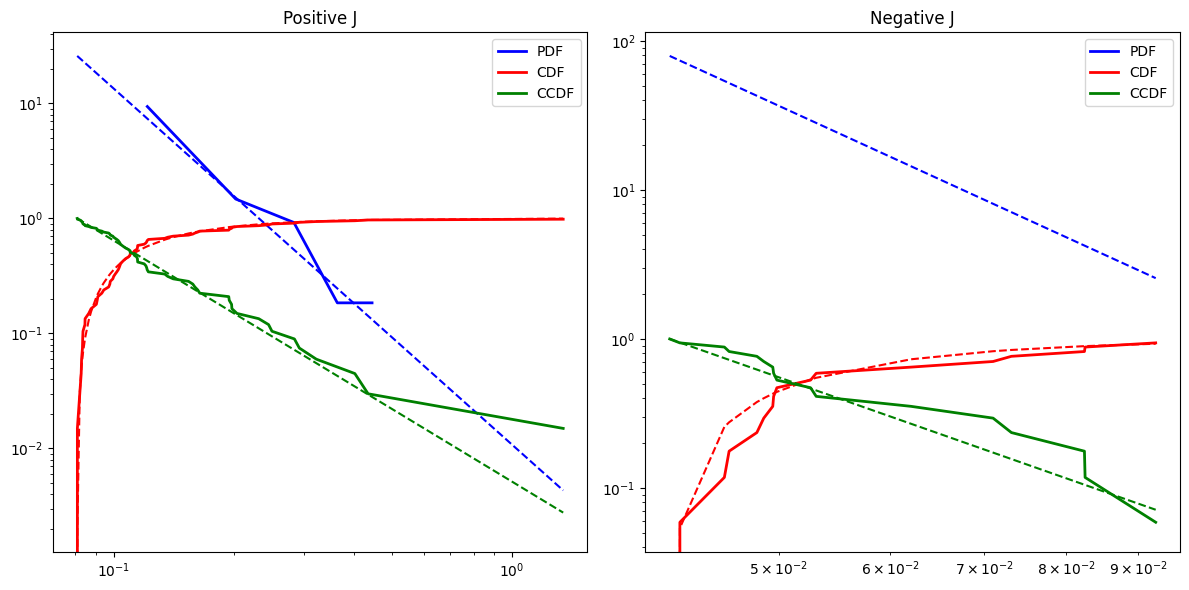

(          Power Law  exponential  lognormal  stretched_exponential
 alpha      3.096459          NaN        NaN                    NaN
 sigma      0.256123          NaN        NaN                    NaN
 xmin       0.080890          NaN        NaN                    NaN
 J min      0.000559          NaN        NaN                    NaN
 J max      1.343536          NaN        NaN                    NaN
 LL Ratio        NaN     1.478927  -0.322093               0.621531
 p-value         NaN     0.139160   0.747382               0.534250,
           Power Law  exponential  lognormal  stretched_exponential
 alpha      4.322659          NaN        NaN                    NaN
 sigma      0.805863          NaN        NaN                    NaN
 xmin       0.041848          NaN        NaN                    NaN
 J min      0.000334          NaN        NaN                    NaN
 J max      0.092628          NaN        NaN                    NaN
 LL Ratio        NaN    -0.807827  -0.668699   

In [ ]:
J_opt_positive, J_opt_negative = extract_J('Results/J_opt.csv')
powerlaw_fit(J_opt_positive, J_opt_negative)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


/Users/mizz/Library/Python/3.9/lib/python/site-packages/powerlaw.py:1507: RuntimeWarning: overflow encountered in divide
  likelihoods = f/C
/Users/mizz/Library/Python/3.9/lib/python/site-packages/powerlaw.py:1615: RuntimeWarning: divide by zero encountered in divide
  CDF = CDF/norm
/Users/mizz/Library/Python/3.9/lib/python/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


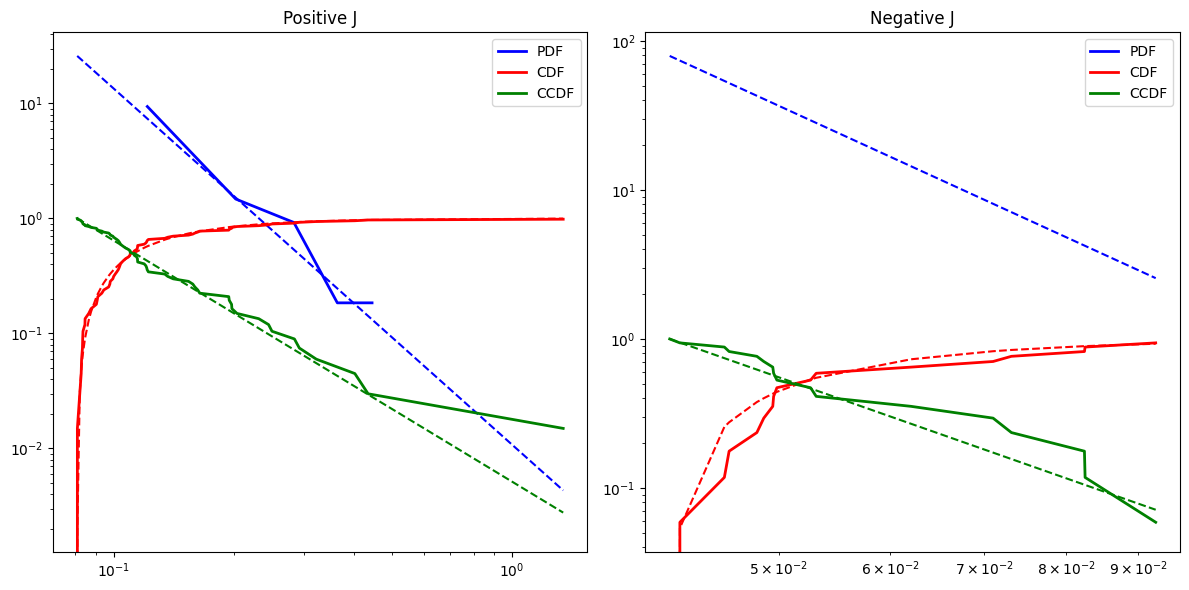

(          Power Law  exponential  lognormal  stretched_exponential
 alpha      3.096459          NaN        NaN                    NaN
 sigma      0.256123          NaN        NaN                    NaN
 xmin       0.080890          NaN        NaN                    NaN
 J min      0.000559          NaN        NaN                    NaN
 J max      1.343536          NaN        NaN                    NaN
 LL Ratio        NaN     1.478927  -0.322093               0.621531
 p-value         NaN     0.139160   0.747382               0.534250,
           Power Law  exponential  lognormal  stretched_exponential
 alpha      4.322659          NaN        NaN                    NaN
 sigma      0.805863          NaN        NaN                    NaN
 xmin       0.041848          NaN        NaN                    NaN
 J min      0.000138          NaN        NaN                    NaN
 J max      0.092628          NaN        NaN                    NaN
 LL Ratio        NaN    -0.807827  -0.668699   

In [ ]:
J_opt_extended_positive, J_opt_extended_negative = extract_J('Results/J_opt_extended.csv')
powerlaw_fit(J_opt_extended_positive, J_opt_extended_negative)